# Model development

This notebook will provide a comprehensive guide to getting started with modelling and prediction in python!

Agenda:

- data preprocessing recap
- introduction to modeling
- examples

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import sklearn
import scipy
import statistics
import tensorflow as tf

from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, Input

In [ ]:
## The dataset

https://www.kaggle.com/code/headsortails/wiki-traffic-forecast-exploration-wtf-eda

The dataset consists of 145000 separate time series, each of which has around some days' worth of data from 2015 to 2016. Each series is measuring the web traffic flow across a wikipedia article.

## The goal

We will be creating a model to forecast the traffic on each of the machines upto several weeks in the future. We will do this using a conventional method, and using deep learning. 

_NOTE: the goal of this workshop is to actually explain the process of building a model, not the theory behind it. Thus, time series analysis will only be covered briefly._

## What do we need to do?

We have preprocessed our data. Now we must choose some models to use on this data and make some predictions. Then we'll evaluate our models' performance!

## Preprocessing

In this section, we port over the preprocessing logic from `preprocessing_matplotlib.ipynb`. In that notebook, we decided we would drop all rows with `NaN` values, except those where the runs of `Nan` values are at most 2 `NaN`s long. We would fill these rows with interpolated values.

While this covers general preprocessing, we will need to do some model-specific preprocessing (and postprocessing) later on.

In [3]:
train_df = pd.read_csv("dataset/train_1.csv")

key_df = pd.read_csv("dataset/key_1.csv")

train_df.set_index("Page", inplace=True, drop=True)
key_df.set_index("Page", inplace=True, drop=True)

# dropping all rows which only contain NaN values
train_df = train_df[~pd.isnull(train_df).all(axis=1)]

# finding all rows where the runs of NaN are of length 2 at most
def find_all(x):
    nan_size = 0
    nan_find = np.isnan(x.values)
    for val in nan_find:
        if val:
            nan_size += 1
            if nan_size > 2:
                return False
        else:
            nan_size = 0
    return True

# dropping all rows which don't satisfy above condition
nan_run_df = train_df.apply(find_all, axis=1)
train_df["keep"] = nan_run_df
nan_run_df.head()

train_df = train_df[train_df["keep"]]

# interpolating values
train_df.interpolate(inplace=True)

del train_df["keep"]

## What is a model?

A model is a function that represents a dataset.

## Why do we need a model?

Datasets are simply a list of numbers. The most we can do is gain some insight into them by calculating results based on their contents, such as an average, or standard deviation. However, to actually make predictions based on the data, gain additional insight, or manipulate the data, we must represent it in a form that gives it mathematical structure.

## Parts of a model

Models have several general parts:

- dataset: the underlying data used to train the model
- parameters (also known as weights or biases): set of fields that describe the dataset
- hyperparameters: set of numbers used to configure the model or parts of the model before it is fitted to the dataset
- fitting algorithm/training loop: algorithm used to deduce the values of the parameters for the model
- prediction function: function that uses the parameters to predict values for inputs to the model
- input space: set of eligible inputs for the prediction function
- ouput space: set of eligible outputs for the prediction function

These parts are very abstract, and will vary quite drastically from model to model.

## An example

Say you have the following data for the result of 10 coin flips of a regular 2-sided coin (heads and tails are equally likely):

HHTHTTHTTT

We could represent this data using a binomial distribution. Recall the definition of a binomial distribution:

$$ X \sim Binom(n, \theta) \rightarrow P(X = x) = \binom{n}{x}\theta^{x}(1-\theta)^{n-x} $$

We have 1 hyperparameter $n$: the size of our dataset. In this case, $n = 10$.

What about $\theta$? Intuition tells us to set $\theta = 0.5$, however we cannot naively do that. Our goal is to fit this binomial distribution to the data we have, not to the general case. So how do we find the best value of $\theta$?

This must be done using a maximum likelihood estimate- recall the steps for that are as follows:

- determine the likelihood function $L(\theta)$.
- determine the log-likelihood function $l(\theta)$.
- determine $\frac{dl}{d\theta}$.
- find $\theta$ such that $l(\theta)$ is maximized.

This is our fitting algorithm. Once these steps are followed, the optimal value of $\theta = 0.4$ is found. We can now say that $X \sim Binom(10, 0.4)$ is our model for the data. $P(X = x)$ is our prediction function- we can now input values of $x$ and see the probability we observe that many heads (WLOG) given the baseline established by our dataset.

Recap:

- dataset: set of 10 observed coin flips (HHTHTTHTTT)
- parameters: $\theta$
- hyperparameters: $n$
- fitting algorithm: procedure for finding maximum likelihood estimate
- prediction function: $P(X = x; \theta)$
- input space: numbers from 0 to 10
- output space: a number from 0 to 1

## Fitting a model

The models we use in practice are of course miles more complex than a simple binomial distribution. They often have thousands or millions of parameters, and these all need to be optimized. We could do this one-by-one but that's infeasible. Instead, algorithms have been developed to determine the parameters iteratively using numerical methods. 

Machine learning is, simply put, the application of the fitting algorithm. Through successive iterations, the computer (or machine) "learns" the dataset- updating its parameters to better represent the dataset.

## Overfitting and underfitting

The fitting algorithm may require some hyperparameters to control how the model is fit to the data. These hyperparamters will affect the results of the training, and therefore need to be set correctly (or reasonably well) to ensure good results.

If the model is fitted using incorrect paramters, we may end up with 1 of 2 scenarios:

### Underfitting

Underfitting occurs when the fitted model does not capture enough features of the model. This can result in bad predictions on many different inputs, but most notably, terrible performance on outliers and more extreme inputs. Graphically, underfitting may look something like this:

![alt text](assets/underfitting.png "Title")

### Overfitting

Overfitting occurs when the fitted model captures too many features of the data. Specifically, this means it becomes very good at recognizing outliers, but very bad at classifying ordinary inputs. This can result in bad predictions on many different inputs, but most notably, terrible performance on ordinary inputs. Graphically, overfitting may look something like this:

![alt text](assets/overfitting.png "Title")

## Configuring a model

Configuring a model may need a substantial amount of trial and error. This will often eman tweaking the hyperparamters in order to ensure optimal performance on the dataset. There are many ways to measure the performance of your model which may prove useful in the configuration stage. While you may start with random values for your hyperparameters, you could use the values of these metrics on different hyperparameters to guide yourself.

There are better techniques for choosing hyperparameters than trial and error, however it's best to reason through it when you're starting out!

## Evaluating performance

When training and testing

## Choosing models for our dataset

Many models are built to perform a specific tasks or to operate on a specific type of data. In this case, our task is time series forecasting. We chose 3 different models to use for this task:

- Decision Tree Regression
- SARIMA (Seasonal Autoregressive Integrated Moving Average)
- RNN (Recurrent Neural Network)

These may or may not be the best models for the job. What matters is how we configure, train, and test them!

## Model 1: Decision Tree Regression

Decision tree regression is a method for regression which employs decision trees to learn local regressions instead of relying on a single, gloabl regression. Each point is fed through a decision tree, eventually reaching a leaf which is then updated to reflecty the average of the values that ended up there. By updating over multiple iterations, the decision tree is tuned so that it can predict for unknown points later on.

Quick facts:

- dataset: one single time series
- parameters: decision tree
- hyperparameters: random state (for initialization)
- fitting algorithm: multiple iterations to create/tune the decision tree
- prediction function: run an unknown point through the decision tree to get a predicted value
- input space: time series sequence of a specified length
- output space: real numbers

### Preprocessing

The decision tree creation relies on a couple of values from our input time series to act as a "hint" to predict the output on. These values are picked in sequence, and are known as lags of the time series. We construct our lags as follows:

To predict the value at $t_n$, we use the values $[t_{n-k}, t_{n-k+1}, ..., t_{n-1}]$ for some value $k$ as our lags for prediction.

We will need to construct lags to enable training. Thus, for each point in the time series from the $k$th point onward, we construct a dataframe of $[t_{n-k}, t_{n-k+1}, ..., t_{n-1}]$. The lag values are stored in the columns $[X_1, X_2, ..., X_k]$. The output value is stored in column $y$.

_Sidenote: Is $k$ a hyperparamter?_ The answer varies based on how you define hyperparamter. Since $k$ is unknown to the model, it is not technically a hyperparameter, though we use it to configure our data for training.

In [5]:
# creates our dataframe of lags
def create_train_test_dtr(row, n_steps=6):
    ret_df = pd.DataFrame(columns=([f"X_{i}" for i in range(1, n_steps + 1)] + ["y"]))
    for i in range(0, n_steps):
        ret_df[f"X_{i + 1}"] = row.shift(-i)
    ret_df["y"] = row.shift(-n_steps)
    return ret_df

# creates our train/test split
def train_test_split_dtr(X, y, train_fraction=0.8):
    return X.iloc[:int(train_fraction*len(X))], \
            X.iloc[int(train_fraction*len(X)):], \
            y.iloc[:int(train_fraction*len(y))], \
            y.iloc[int(train_fraction*len(y)):]

train_test_df = create_train_test_dtr(train_df.iloc[0]).dropna()

X = train_test_df[[f"X_{i}" for i in range(1, 7)]]
y = train_test_df["y"]

X_train, X_test, y_train, y_test = train_test_split_dtr(X, y)

In [6]:
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

# model creation and training
dt_reg = DecisionTreeRegressor(random_state=42)

dt_reg.fit(X_train, y_train)

# model prediction
dt_reg_pred = dt_reg.predict(X_test)

[Text(0.0, 0, '2016-09-08'),
 Text(20.0, 0, '2016-09-28'),
 Text(40.0, 0, '2016-10-18'),
 Text(60.0, 0, '2016-11-07'),
 Text(80.0, 0, '2016-11-27'),
 Text(100.0, 0, '2016-12-17')]

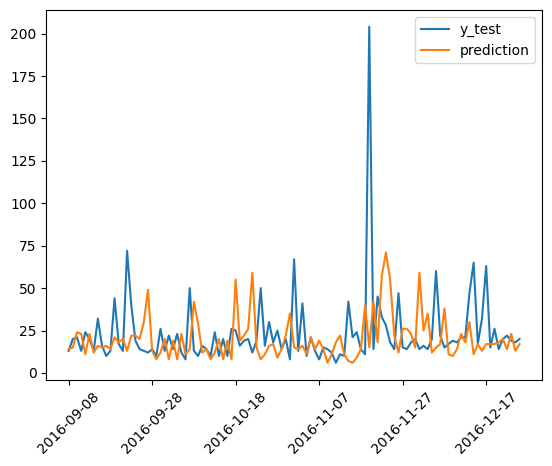

In [7]:
# plotting our test answers vs our prediction
fig, ax = plt.subplots()

plt.plot(y_test, label="y_test")
plt.plot(dt_reg_pred, label="prediction")
plt.legend()

ax.set_xticks(y_test.index[::20])
ax.set_xticklabels(y_test.index[::20], rotation=45)

## Metrics for error

So how did we do? While the plot does not look bad, we have no way of quantifying the accuracy of our predictions using the graph. Thus, we rely on a few different error metrics to glean our performance (note: $a$ is acutal value, $e$ is expected value):

- mean absolute error: $\frac{1}{n}\sum^{n}_{i = 1}|e_i-a_i|$
- mean squared error: $\frac{1}{n}\sum^{n}_{i = 1}(e_i-a_i)^2$
- root mean squared error: $\sqrt{\frac{1}{n}\sum^{n}_{i = 1}(e_i-a_i)^2}$

In [14]:
def mean_absolute_error(x, y):
    return statistics.mean(list(map(lambda x, y: abs(y - x), x, y)))

def mean_squared_error(x, y):
    return statistics.mean(list(map(lambda x, y: (y - x) ** 2, x, y)))

def root_mean_squared_error(x, y):
    return math.sqrt(statistics.mean(list(map(lambda x, y: (y - x) ** 2, x, y))))

15.119266055045872
707.816513761468
26.604821250319798


In [ ]:
# error statistics for decision tree regression

print(mean_absolute_error(y_test, dt_reg_pred))
print(mean_squared_error(y_test, dt_reg_pred))
print(root_mean_squared_error(y_test, dt_reg_pred))

## Model 2: SARIMA



### Preprocessing

Luckily for us, none is required! We simply create our train/test split.

In [81]:
# input
X = train_df.iloc[0]

# creating train/test split
def train_test_split_sarima(X, y, train_fraction=0.8):
    return X.iloc[:int(train_fraction*len(X))], \
            X.iloc[int(train_fraction*len(X)):], \
            y.iloc[:int(train_fraction*len(y))], \
            y.iloc[int(train_fraction*len(y)):]

X_train, X_test, _, _ = train_test_split_sarima(X, X)

# creating model
arma_model = SARIMAX(X_train, order = (2, 2, 2), seasonal_order=(2,2,2,12))

# fitting model
arma_model = arma_model.fit()

# creating predictions using model
y_pred = arma_model.get_forecast(len(X_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df = arma_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

2015-07-01    18.0
2015-07-02    11.0
2015-07-03     5.0
2015-07-04    13.0
2015-07-05    14.0
              ... 
2016-12-27    20.0
2016-12-28    22.0
2016-12-29    19.0
2016-12-30    18.0
2016-12-31    20.0
Name: 2NE1_zh.wikipedia.org_all-access_spider, Length: 550, dtype: float64


/Users/abhijain/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/abhijain/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/abhijain/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33488D+00    |proj g|=  1.22436D-01


 This problem is unconstrained.



At iterate    5    f=  5.29246D+00    |proj g|=  8.51112D-03

At iterate   10    f=  5.25196D+00    |proj g|=  9.47899D-02

At iterate   15    f=  5.01046D+00    |proj g|=  6.39148D-02

At iterate   20    f=  4.97699D+00    |proj g|=  3.89184D-02

At iterate   25    f=  4.87705D+00    |proj g|=  4.70144D-02

At iterate   30    f=  4.87390D+00    |proj g|=  5.21688D-03

At iterate   35    f=  4.85719D+00    |proj g|=  4.91831D-02

At iterate   40    f=  4.85220D+00    |proj g|=  7.45735D-03

At iterate   45    f=  4.84609D+00    |proj g|=  2.11006D-02


/Users/abhijain/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.84109D+00    |proj g|=  2.65354D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   2.654D-03   4.841D+00
  F =   4.8410889852271177     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Text(0.0, 0, '2016-09-13'),
 Text(20.0, 0, '2016-10-03'),
 Text(40.0, 0, '2016-10-23'),
 Text(60.0, 0, '2016-11-12'),
 Text(80.0, 0, '2016-12-02'),
 Text(100.0, 0, '2016-12-22')]

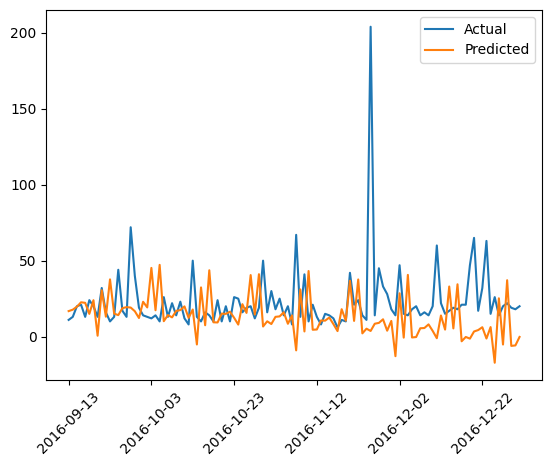

In [84]:
# plotting our test data vs our prediction
fig, ax = plt.subplots()

plt.plot(X_test, label="Actual")
plt.plot(y_pred_df.values, label="Predicted")
plt.legend()

ax.set_xticks(X_test.index[::20])
ax.set_xticklabels(X_test.index[::20], rotation=45)

## Model 3: RNN



### Preprocessing

The decision tree creation relies on a couple of values from our input time series to act as a "hint" to predict the output on. These values are picked in sequence, and are known as lags of the time series. We construct our lags as follows:

To predict the value at $t_n$, we use the values $[t_{n-k}, t_{n-k+1}, ..., t_{n-1}]$ for some value $k$ as our lags for prediction.

We will need to construct lags to enable training. Thus, for each point in the time series from the $k$th point onward, we construct a dataframe of $[t_{n-k}, t_{n-k+1}, ..., t_{n-1}]$. The lag values are stored in the columns $[X_1, X_2, ..., X_k]$. The output value is stored in column $y$.

In [62]:
# creates lags and the train/test split in 1 go
def create_train_test_nn(row, n_steps=6):
    ret_df = pd.DataFrame(columns=([f"X_{i}" for i in range(1, n_steps + 1)] + ["y"]))
    for i in range(0, n_steps):
        ret_df[f"X_{i + 1}"] = row.shift(-i)
    ret_df["y"] = row.shift(-n_steps)
    ret_df = ret_df.reset_index().dropna()
    return ret_df.iloc[:int(0.8*len(ret_df))], ret_df.iloc[int(0.8*len(ret_df)):]

# setting up scaler for values
train_nn_scaler = StandardScaler()

# scaling values
train_nn_df = pd.DataFrame(train_nn_scaler.fit_transform(train_df))

# creating dataframes
train_nn_formatted, test_nn_formatted = create_train_test_nn(train_nn_df.iloc[0], n_steps=25)

# note: we are limiting to 2000 time series since i don't want my computer to explode
for i in range(1, 2000):
    if not i % 100: print(i)
    train_nn_formatted_addition, test_nn_formatted_addition = create_train_test_nn(train_nn_df.iloc[i], n_steps=25)
    train_nn_formatted = pd.concat([train_nn_formatted, train_nn_formatted_addition], ignore_index=True)
    test_nn_formatted = pd.concat([test_nn_formatted, test_nn_formatted_addition], ignore_index=True)

             0         1         2         3         4         5         6     
0      -0.016338 -0.016200 -0.016354 -0.016110 -0.016476 -0.016049 -0.016387  \
1      -0.016433 -0.016160 -0.016212 -0.016042 -0.016516 -0.016000 -0.016217   
2      -0.016570 -0.016347 -0.016411 -0.016274 -0.016664 -0.016111 -0.016505   
3      -0.016107 -0.016174 -0.016283 -0.015005 -0.016610 -0.015840 -0.016322   
4      -0.016420 -0.016254 -0.016369 -0.016219 -0.016395 -0.016062 -0.016439   
...          ...       ...       ...       ...       ...       ...       ...   
122039 -0.016188 -0.016134 -0.016340 -0.016138 -0.016221 -0.016111 -0.016361   
122040 -0.016529 -0.016013 -0.016326 -0.016138 -0.016583 -0.016086 -0.016295   
122041 -0.016583 -0.016321 -0.016340 -0.016206 -0.016570 -0.016098 -0.016452   
122042 -0.016542 -0.016214 -0.015842 -0.016056 -0.016449 -0.015988 -0.016400   
122043 -0.016542 -0.016214 -0.016426 -0.016274 -0.016637 -0.016160 -0.016505   

             7         8         9    .

In [63]:
# reshaping time series so the model can use it
X_train = np.array(train_nn_formatted[[f"X_{i}" for i in range(1, 26)]].values).reshape(-1, 1, 25)
y_train = train_nn_formatted["y"].values
X_test = np.array(test_nn_formatted[[f"X_{i}" for i in range(1, 26)]].values).reshape(-1, 1, 25)
y_test = test_nn_formatted["y"].values

(840000, 1, 25)

In [64]:
# creating model
model = Sequential([
    Input(shape=(1, 25)),
    LSTM(units=25, input_shape=(1, 25), return_sequences=True, activation=tf.nn.relu),
    LSTM(units=10, input_shape=(25, ), activation=tf.nn.relu),
    Dense(1)
])

# setting up model
model.compile(optimizer="adam", loss="mean_squared_error")

# fitting model
model.fit(X_train, y_train, epochs=15, batch_size=2000)

# making predictions
model_results = model.predict(X_test)

Epoch 1/15
420/420 [==============================] - 3s 4ms/step - loss: 2.7420e-05 - accuracy: 0.0000e+00
Epoch 2/15
420/420 [==============================] - 2s 4ms/step - loss: 1.2458e-05 - accuracy: 0.0000e+00
Epoch 3/15
420/420 [==============================] - 2s 4ms/step - loss: 9.5861e-06 - accuracy: 0.0000e+00
Epoch 4/15
420/420 [==============================] - 2s 4ms/step - loss: 8.3006e-06 - accuracy: 0.0000e+00
Epoch 5/15
420/420 [==============================] - 1s 4ms/step - loss: 7.9666e-06 - accuracy: 0.0000e+00
Epoch 6/15
420/420 [==============================] - 2s 4ms/step - loss: 7.4722e-06 - accuracy: 0.0000e+00
Epoch 7/15
420/420 [==============================] - 2s 4ms/step - loss: 7.6401e-06 - accuracy: 0.0000e+00
Epoch 8/15
420/420 [==============================] - 2s 4ms/step - loss: 6.9939e-06 - accuracy: 0.0000e+00
Epoch 9/15
420/420 [==============================] - 2s 4ms/step - loss: 7.2271e-06 - accuracy: 0.0000e+00
Epoch 10/15
420/420 [=======

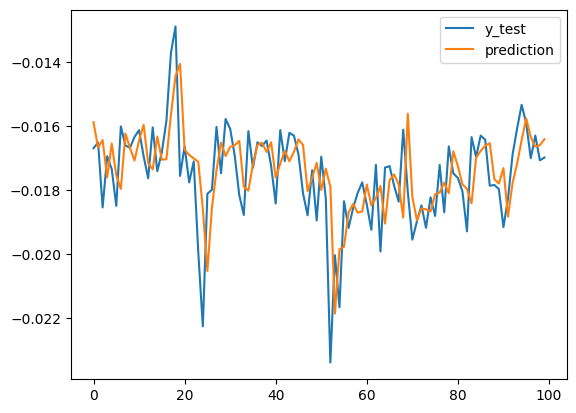

In [89]:
# plotting predictions
fig, ax = plt.subplots()

plt.plot(y_test[:100], label="y_test")
plt.plot(model_results[:100], label="prediction")
plt.legend()

In [ ]:
# forecasting a specific time series



In [66]:
# error on the sample time series
print(mean_absolute_error(y_test, model_results.reshape(-1)))
print(mean_squared_error(y_test, model_results.reshape(-1)))
print(root_mean_squared_error(y_test, model_results.reshape(-1)))

0.0009799713308556472
2.8398403410650966e-06
0.0016851825838956136


## What's next?